In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
#from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
n_in = 168 #历史数量
n_out = 24 #预测数量
n_features = 1
# n_test = 1
n_val = 1
n_epochs = 250

In [4]:
#d导入数据
def load_stw_data() -> pd.DataFrame:
    
    df_stw = pd.read_excel('data3.xlsx')
    df_stw.columns = ['BillingDate', 'VolumnHL']
    
    return df_stw

In [5]:
#MinMaxScaler数据归一化，可以帮助网络模型更快的拟合，稍微有一些提高准确率的效果
def minmaxscaler(data: pd.DataFrame) -> pd.DataFrame:
    
    volume = data.VolumnHL.values
    volume = volume.reshape(len(volume), 1)
    volume = scaler.fit_transform(volume)
    volume = volume.reshape(len(volume),)    
    data['VolumnHL'] = volume
        
    return data

In [6]:
#划分训练数据集和验证数据集,这里需要注意的是我么需要预测的数据是不可以出现在训练中的，切记。
def split_data(x, y, n_test: int):
    
    x_train = x[:-n_val-n_out+1]
    x_val = x[-n_val:]
    y_train = y[:-n_val-n_out+1]
    y_val = y[-n_val:]
    
    return x_train, y_train, x_val, y_val

In [7]:
#划分X和Y
def build_train(train, n_in, n_out):
    
    train = train.drop(["BillingDate"], axis=1)
    X_train, Y_train = [], []
    for i in range(train.shape[0]-n_in-n_out+1):
        X_train.append(np.array(train.iloc[i:i+n_in]))
        Y_train.append(np.array(train.iloc[i+n_in:i+n_in+n_out]["VolumnHL"]))
        
    return np.array(X_train), np.array(Y_train)

In [8]:
#构建最简单的LSTM
def build_lstm(n_in: int, n_features: int):
    
    model = Sequential()
    model.add(LSTM(12, activation='relu', input_shape=(n_in, n_features)))
    model.add(Dropout(0.3))





    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mae')
    
    return model

In [9]:
#模型拟合
def model_fit(x_train, y_train, x_val, y_val, n_features):
    
    model = build_lstm(
        n_in   = n_in,
        n_features= 1
    )
    model.compile(loss='mae', optimizer='adam')
    model.fit(x_train, y_train, epochs=n_epochs, batch_size=128, verbose=1,  validation_data=(x_val, y_val))
    m = model.evaluate(x_val, y_val)
    print(m)
    
    return model

In [11]:
data = load_stw_data()
scaler = MinMaxScaler(feature_range=(0, 1))
data = minmaxscaler(data)

In [12]:
data_copy = data.copy()
x, y = build_train(data_copy, n_in, n_out)
x_train, y_train, x_val, y_val = split_data(x, y, n_val)
model = build_lstm(n_in, 1)
model = model_fit(x_train, y_train, x_val, y_val, 1)
predict = model.predict(x_val)  

Epoch 1/250
5/5 [==============================] - 3s 138ms/step - loss: 0.6101 - val_loss: 0.6043
Epoch 2/250
5/5 [==============================] - 0s 73ms/step - loss: 0.5986 - val_loss: 0.5907
Epoch 3/250
5/5 [==============================] - 0s 65ms/step - loss: 0.5878 - val_loss: 0.5775
Epoch 4/250
5/5 [==============================] - 0s 64ms/step - loss: 0.5756 - val_loss: 0.5645
Epoch 5/250
5/5 [==============================] - 0s 61ms/step - loss: 0.5645 - val_loss: 0.5515
Epoch 6/250
5/5 [==============================] - 0s 54ms/step - loss: 0.5537 - val_loss: 0.5381
Epoch 7/250
5/5 [==============================] - 0s 57ms/step - loss: 0.5422 - val_loss: 0.5240
Epoch 8/250
5/5 [==============================] - 0s 58ms/step - loss: 0.5314 - val_loss: 0.5130
Epoch 9/250
5/5 [==============================] - 0s 56ms/step - loss: 0.5172 - val_loss: 0.5019
Epoch 10/250
5/5 [==============================] - 0s 60ms/step - loss: 0.5055 - val_loss: 0.4897
Epoch 11/250
5/5 [

In [13]:

# predict = model.predict(x_val)  
validation = scaler.inverse_transform(predict)[0]
validation

array([610998.56, 561236.3 , 535507.3 , 500181.38, 498918.06, 493795.47,
       490514.3 , 484921.8 , 488440.47, 501906.06, 528748.8 , 553554.44,
       562784.94, 583302.8 , 602088.25, 635911.2 , 663386.25, 691759.7 ,
       699382.6 , 712310.  , 703794.56, 669467.2 , 661640.06, 639040.06],
      dtype=float32)

In [14]:
actual = scaler.inverse_transform(y_val)[0]
actual

array([639457., 620449., 611584., 493739., 323143., 329209., 350783.,
       403793., 449446., 489899., 528206., 563321., 594820., 608519.,
       616327., 626740., 640685., 673864., 739997., 789165., 818590.,
       804708., 748938., 694595.])

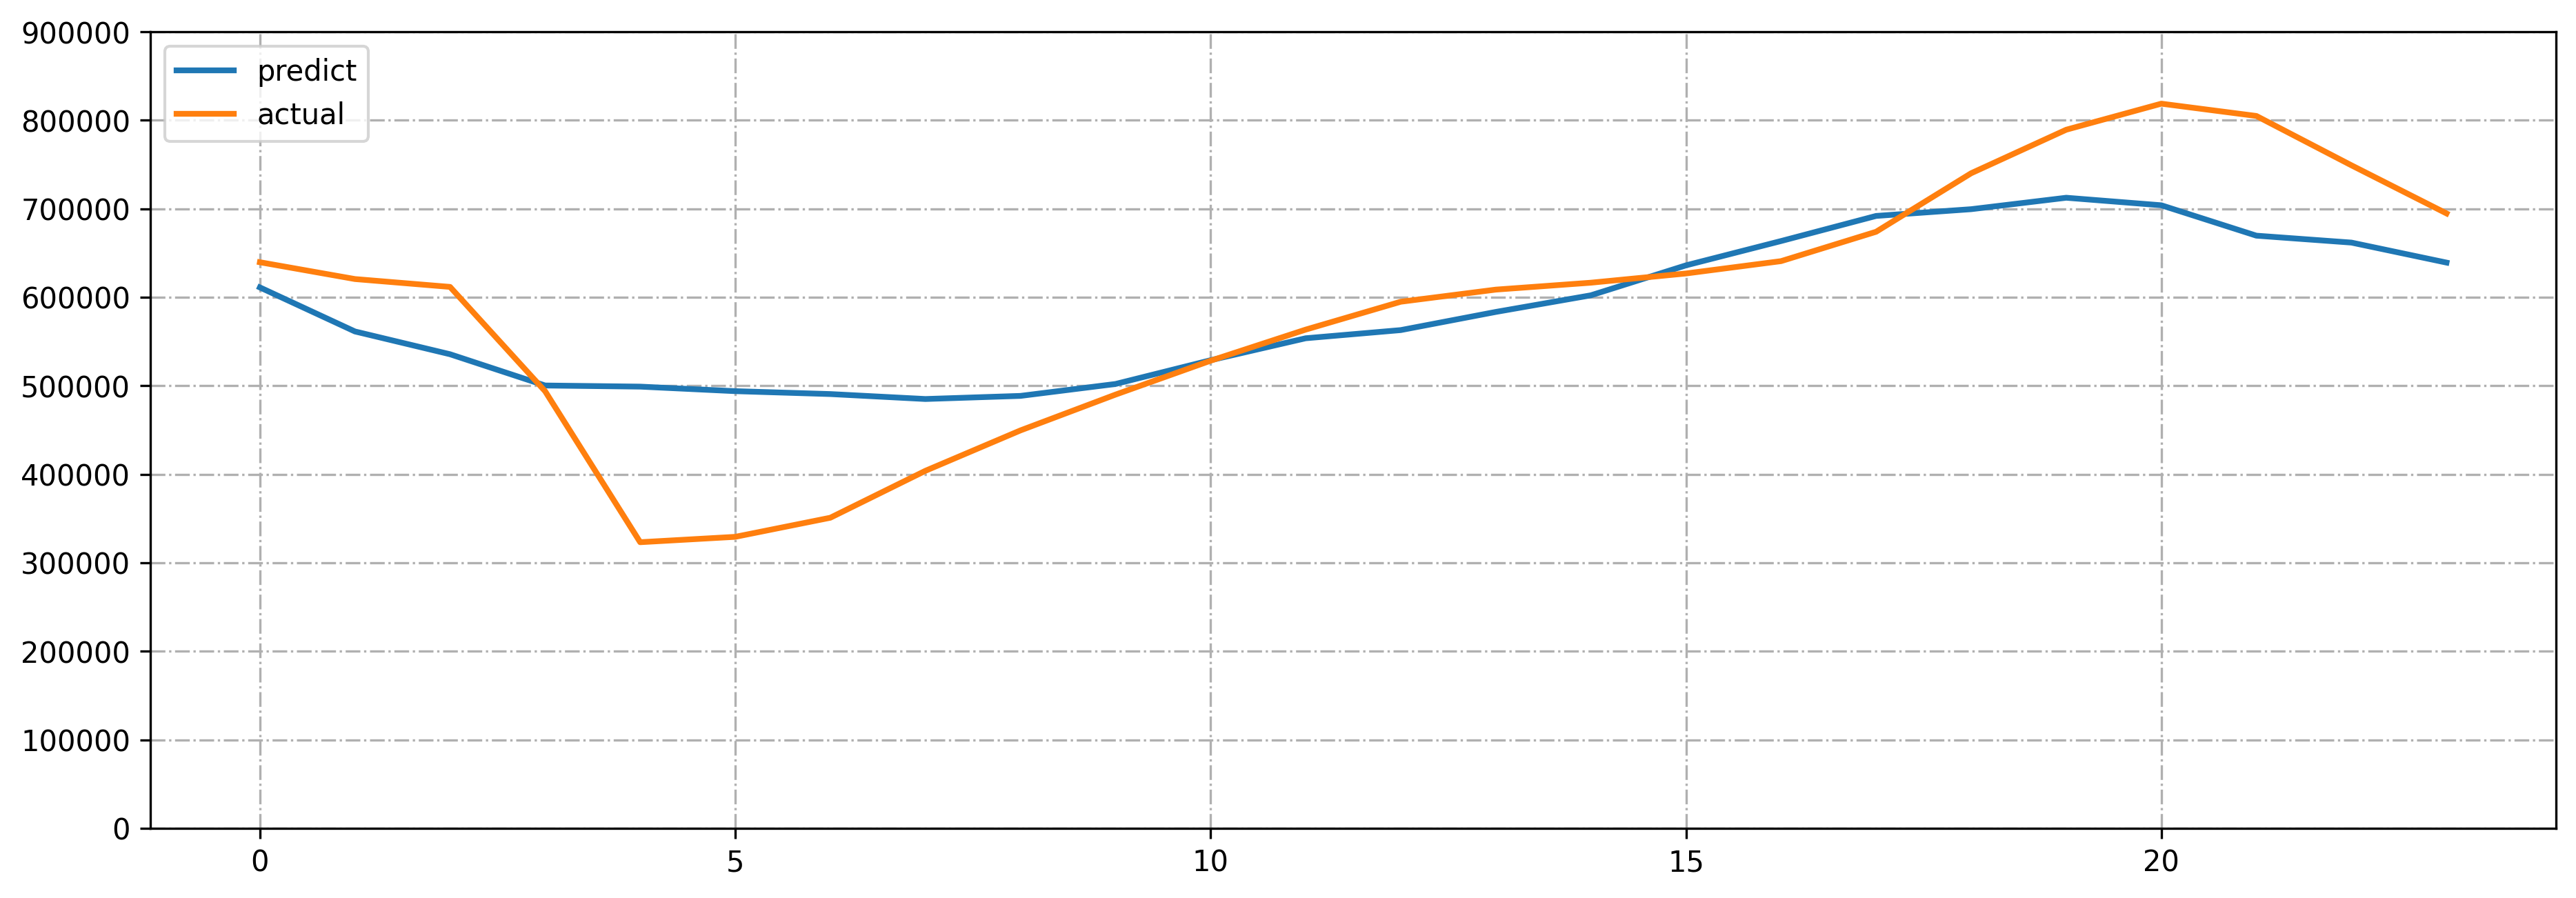

In [16]:
predict = validation
actual = actual
x = [x for x in range(24)]
fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
ax.plot(x, predict, linewidth=2.0,label = "predict")
ax.plot(x, actual, linewidth=2.0,label = "actual")
ax.legend(loc=2)
# ax.set_title(bf_name)
plt.ylim((0, 900000))
plt.grid(linestyle='-.')
plt.show()

In [17]:
#ACC
error = 0
summery = 0
for i in range(24):
    error += abs(predict[i] - actual[i])
    summery += actual[i]
acc = 1 - error/summery
acc

0.8994108977013169